### Importing the libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

# For data processing
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, MinMaxScaler,StandardScaler

# For model training and evaluation
from pycaret.classification import (
    setup,
    compare_models,
    evaluate_model,
    predict_model,
    save_model,
    load_model,
)
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc

print("Everything imported succesfully !")

Everything imported succesfully !


In [2]:
# Reading the data from the csv file
df = pd.read_csv("diabetes.csv")

### Exploratory data analysis

In [3]:
# Let's check the shape of the dataset
print("The shape of the dataframe :", df.shape)

The shape of the dataframe : (768, 9)


In [4]:
# Let's take look at 5 random rows from the dataset
df.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
91,4,123,80,15,176,32.0,0.443,34,0
479,4,132,86,31,0,28.0,0.419,63,0
245,9,184,85,15,0,30.0,1.213,49,1
767,1,93,70,31,0,30.4,0.315,23,0
360,5,189,64,33,325,31.2,0.583,29,1


In [5]:
# Let's get some basic information about our data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB



- All the features in our dataset are numerical features.
- We can reduce the memory usage we can use float32 and int32 datatypes
- There are no missing values present

In [6]:
int_cols = df.select_dtypes(include=np.int64)
float_cols = df.select_dtypes(include=np.float64)

# Changing the datatype from 64 bit to 32 bit
df[int_cols.columns] = df[int_cols.columns].astype(np.int32)
df[float_cols.columns] = df[float_cols.columns].astype(np.float32)

In [7]:
# Let's check if there are any duplicate values
print("Total duplicate values : ", df.duplicated().sum())

Total duplicate values :  0


In [8]:
# Let's get a descriptive information
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992579,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884161,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.299999,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.599998,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.099998,2.420000,81.000000,1.000000


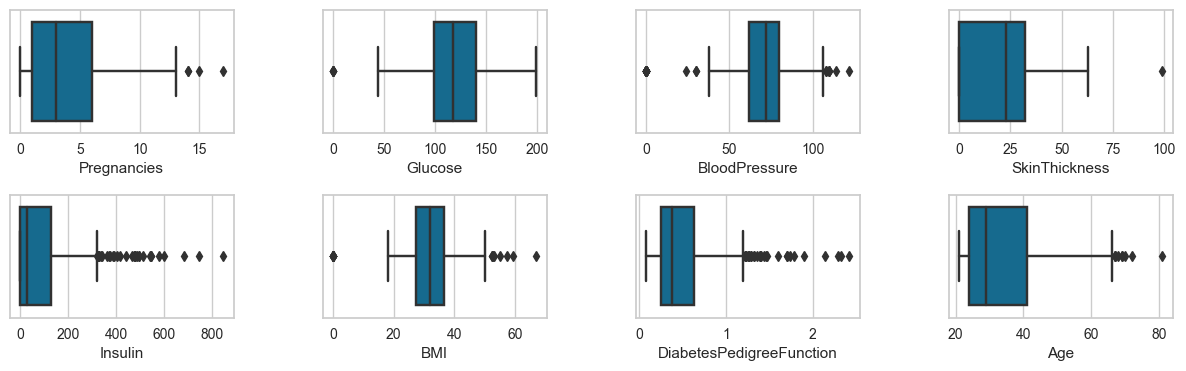

In [9]:
# Let's check if there are any outliers
fig, ax = plt.subplots(2, 4, figsize=(15, 4))

sns.boxplot(x=df["Pregnancies"], ax=ax[0][0])
sns.boxplot(x=df["Glucose"], ax=ax[0][1])
sns.boxplot(x=df["BloodPressure"], ax=ax[0][2])
sns.boxplot(x=df["SkinThickness"], ax=ax[0][3])

sns.boxplot(x=df["Insulin"], ax=ax[1][0])
sns.boxplot(x=df["BMI"], ax=ax[1][1])
sns.boxplot(x=df["DiabetesPedigreeFunction"], ax=ax[1][2])
sns.boxplot(x=df["Age"], ax=ax[1][3])

plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()

### Data processing using pipeline

**For dealing with outliers**

Since out dataset is small thus, first instead of simply removing or capping the outliers we will transform the data using the Yeo-Johnson transformation and will train our model after that we will check if we need to remove or cap the outliers.

**For normalizing the values**
We will be using something

In [10]:
# Column transformer for dealing with outliers
yeo_transformation = ColumnTransformer(
    transformers=[("Yeo-Johnson", PowerTransformer(), [0, 1, 2, 3, 4, 5, 6, 7])],
    remainder="passthrough",
)

# Column transformer to do feature scaling
scaling_transformer = ColumnTransformer(
    transformers=[("scale_transformer", MinMaxScaler(), [0, 1, 2, 3, 4, 5, 6, 7])],
    remainder="passthrough",
)

# Let's build a pipeline
pipe = Pipeline(
    steps=[
        # ('Yeo-Johnson-Transformation', yeo_transformation),
        ("Scaling", scaling_transformer),
    ]
)

In [11]:
# Seperating the data into dependent and independent variables
X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

# Let's do train test and validation split ( 70 : 15 : 15 )
X_train, X_test_val, y_train, y_test_val = train_test_split(
    X, y, test_size=0.3, random_state=0
)
X_val, X_test, y_val, y_test = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=0
)

In [12]:
# Let's pass the training data throug the pipeline
X_train = pipe.fit_transform(X_train)
X_val = pipe.fit_transform(X_val)

### Model building

In [13]:
# Intializing the setup with preprocessing
clf = setup(X_train, target=y_train, preprocess=False, use_gpu=True)

# compare selected models
best_model = compare_models(
    include=[
        "lr",
        "knn",
        "nb",
        "dt",
        "svm",
        "rbfsvm",
        "gpc",
        "mlp",
        "ridge",
        "rf",
        "qda",
        "ada",
        "gbc",
        "lda",
        "et",
        "lightgbm",
        "dummy",
    ]
)

,Description,Value
0,Session id,3991
1,Target,target
2,Target type,Binary
3,Original data shape,"(537, 9)"
4,Transformed data shape,"(537, 9)"
5,Transformed train set shape,"(375, 9)"
6,Transformed test set shape,"(162, 9)"
7,Numeric features,8


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.7679,0.0000,0.5846,0.7243,0.6380,0.4721,0.4839,0.1410
lr,Logistic Regression,0.7626,0.8170,0.5846,0.7130,0.6330,0.4622,0.4735,0.1530
lda,Linear Discriminant Analysis,0.7626,0.8182,0.5846,0.7130,0.6330,0.4622,0.4735,0.1630
nb,Naive Bayes,0.7574,0.7950,0.6220,0.6859,0.6451,0.4629,0.4697,0.1360
et,Extra Trees Classifier,0.7520,0.8050,0.5912,0.6776,0.6239,0.4423,0.4495,0.8550
rbfsvm,SVM - Radial Kernel,0.7494,0.8173,0.5407,0.7053,0.6018,0.4261,0.4398,0.1660
gbc,Gradient Boosting Classifier,0.7467,0.7643,0.5918,0.6771,0.6199,0.4335,0.4452,0.5000
rf,Random Forest Classifier,0.7440,0.7906,0.5538,0.6887,0.5998,0.4180,0.4327,0.8830
gpc,Gaussian Process Classifier,0.7414,0.8072,0.5253,0.6887,0.5894,0.4072,0.4188,0.6330
qda,Quadratic Discriminant Analysis,0.7361,0.7857,0.5846,0.6488,0.6105,0.4128,0.4170,0.1520


In [14]:
predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.7716,0.7263,0.5593,0.7500,0.6408,0.4785,0.4896


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,target,prediction_label
530,-0.839162,2.311417,0.325677,0.934609,1.384909,0.528824,1.208267,-0.389450,1,1
99,0.336650,2.094109,-0.291395,0.747292,2.026309,-0.131446,0.334272,-0.389450,1,1
167,-1.133115,0.603999,-3.582443,-1.313197,-0.716523,1.263843,-0.797132,-0.389450,1,1
366,0.924556,1.442186,0.942748,1.309244,1.992552,0.740609,0.944871,0.527807,1,1
175,0.042697,-0.047924,-0.085704,-1.313197,-0.716523,-0.330773,0.711407,0.027485,0,0
...,...,...,...,...,...,...,...,...,...,...
77,-0.251256,0.262515,0.428522,0.122901,-0.049804,-0.480268,-0.443942,0.027485,1,0
444,-0.839162,1.845757,0.428522,1.309244,1.756246,0.964852,2.354636,-0.973158,1,1
325,0.924556,1.162790,-0.291395,-1.313197,-0.716523,-0.604848,-0.530743,0.527807,0,1
119,-0.839162,0.355647,1.662665,0.435097,0.465005,0.067881,-0.710331,0.944741,1,0


In [15]:
# Let's save the model for now before optimization
save_model(best_model, model_name='ridge-model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\ys723\AppData\Local\Temp\joblib),
          steps=[('placeholder', None),
                 ('trained_model',
                  RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True,
                                  fit_intercept=True, max_iter=None,
                                  positive=False, random_state=3991,
                                  solver='auto', tol=0.0001))],
          verbose=False),
 'ridge-model.pkl')

### Hyper-Paraemter optimzation using Optuna

In [13]:
def objective(trial):
    alpha = trial.suggest_float('alpha', 1e-3, 1e3)
    cls = RidgeClassifier(alpha=alpha)
    scores = sklearn.model_selection.cross_val_score(
        cls, X_val, y_val, n_jobs=-1, cv=5
    )
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-07-06 17:29:33,009] A new study created in memory with name: no-name-c85696ec-52f3-4cf6-bb67-6fe43c7efb54
[I 2023-07-06 17:29:35,965] Trial 0 finished with value: 0.6347826086956522 and parameters: {'alpha': 548.2022052207482}. Best is trial 0 with value: 0.6347826086956522.
[I 2023-07-06 17:29:37,186] Trial 1 finished with value: 0.6347826086956522 and parameters: {'alpha': 465.8944806800915}. Best is trial 0 with value: 0.6347826086956522.
[I 2023-07-06 17:29:38,342] Trial 2 finished with value: 0.6347826086956522 and parameters: {'alpha': 145.70819909682146}. Best is trial 0 with value: 0.6347826086956522.
[I 2023-07-06 17:29:39,225] Trial 3 finished with value: 0.6347826086956522 and parameters: {'alpha': 175.0104251026774}. Best is trial 0 with value: 0.6347826086956522.
[I 2023-07-06 17:29:39,257] Trial 4 finished with value: 0.6347826086956522 and parameters: {'alpha': 563.0648996514445}. Best is trial 0 with value: 0.6347826086956522.
[I 2023-07-06 17:29:39,290] Trial 5

In [14]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters {}".format(trial.params))

Accuracy: 0.765217391304348
Best hyperparameters {'alpha': 0.16501752565697925}


In [15]:
# Let's now train the model with these parameters
model = RidgeClassifier(alpha=0.16501752565697925)

model.fit(X_train,y_train)
X_test = pipe.fit_transform(X_test)
y_pred = model.predict(X_test)

In [16]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

Accuracy: 0.7327586206896551
Precision: 0.5094339622641509
Recall: 0.84375
F1 score: 0.6352941176470588


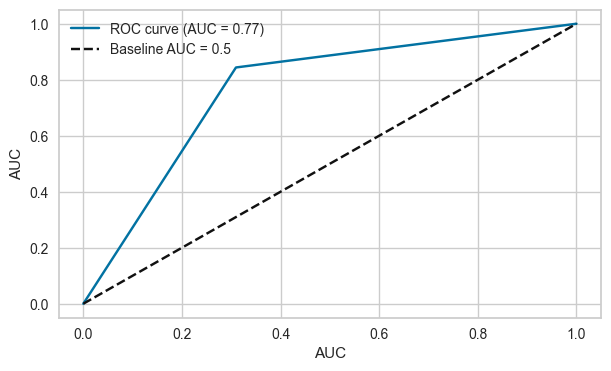

In [26]:
# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)

# Calculate the AUC
auc_value = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(7, 4))
plt.plot(fpr, tpr, label='ROC curve (AUC = {0:.2f})'.format(auc_value))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()

# Plot the AUC curve
plt.plot([0, 1], [0, 1], 'k--', label='Baseline AUC = 0.5')
plt.xlabel('AUC')
plt.ylabel('AUC')
plt.legend()
plt.show()